In [2]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
import glob

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

%matplotlib notebook

In [63]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-17_11-39-17_646318\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-18_10-44-55_646318\processed",
    r"Y:\2023-02-27_08-14-30_649944\processed",
    r"Y:\2023-02-28_09-33-43_649944\processed",
]


In [64]:
#define whether trial stimuli were in the rewarded modality

def trialStimInModality(trials):

    trialStimInRewardedModality = np.zeros(len(trials)).astype(bool)
    trialRewardedModality = []
    trialStimModality = []

    for tt,trial in trials.iterrows():

        if trial['trialStimID']!='catch':
            rew_mod=trial['trialstimRewarded'][:-1]
            stim_mod=trial['trialStimID'][:-1]

            trialRewardedModality.append(rew_mod)
            trialStimModality.append(stim_mod)

            trialStimInRewardedModality[tt] = stim_mod==rew_mod
        else:
            trialRewardedModality.append('')
            trialStimModality.append('')

    trials['trialStimModality']=trialStimModality
    trials['trialRewardedModality']=trialRewardedModality   
    trials['trialStimInRewardedModality']=trialStimInRewardedModality
    
    return(trials)

In [75]:
# loop through sessions

session_date=[]
mouse_id=[]

#units
total_n=[]
probeA_n=[]
probeB_n=[]
probeC_n=[]
probeD_n=[]
probeE_n=[]
probeF_n=[]

VIS_n=[]
AUD_n=[]

#trials
n_trials=[]
n_vis_block_trials=[]
n_aud_block_trials=[]
n_catch=[]

vis_go_500=[]
vis_go_750=[]
vis_go_1000=[]

vis_nogo_500=[]
vis_nogo_750=[]
vis_nogo_1000=[]

aud_go_500=[]
aud_go_750=[]
aud_go_1000=[]

aud_nogo_500=[]
aud_nogo_750=[]
aud_nogo_1000=[]

hit_rate=[]
fa_rate=[]
fa_rel_rate=[]
fa_irrel_rate=[]

for ss in main_path:
    session=Session(path=ss) 
    session.assign_unit_areas()
    
    
    # get mouse number and recording date
    if "recordings" in ss:
        sub1 = "recordings"
    elif "Y:" in ss:
        sub1 = "Y:"
    sub2 = "\\processed"
    idx1 = ss.index(sub1)
    idx2 = ss.index(sub2)
    exp_folder=ss[idx1 + len(sub1) + 1: idx2]
    mouse=exp_folder[-6:]
    exp=exp_folder[:-7]
    
    session_date.append(exp_folder)
    mouse_id.append(session.metadata['mouseID'])
    
    session.trials = trialStimInModality(session.trials)
    
    #unit info table
    total_n.append(len(session.good_units))
    probeA_n.append(len(session.good_units.query('probe == "A"')))
    probeB_n.append(len(session.good_units.query('probe == "B"')))
    probeC_n.append(len(session.good_units.query('probe == "C"')))
    probeD_n.append(len(session.good_units.query('probe == "D"')))
    probeE_n.append(len(session.good_units.query('probe == "E"')))
    probeF_n.append(len(session.good_units.query('probe == "F"')))
    
    VIS_n.append(len(session.good_units.query('area.str.contains("VIS") and probe == "B"')))
    AUD_n.append(len(session.good_units.query('area.str.contains("AUD") and probe == "C"')))
    
    #trial info table
    n_trials.append(len(session.trials))
    n_vis_block_trials.append(len(session.trials.query('trialRewardedModality == "vis"')))
    n_aud_block_trials.append(len(session.trials.query('trialRewardedModality == "sound"')))
    
    vis_go_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "vis1"')))
    vis_go_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "vis1"')))
    vis_go_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "vis1"')))

    vis_nogo_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "vis2"')))
    vis_nogo_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "vis2"')))
    vis_nogo_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "vis2"')))

    aud_go_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "sound1"')))
    aud_go_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "sound1"')))
    aud_go_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "sound1"')))

    aud_nogo_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "sound2"')))
    aud_nogo_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "sound2"')))
    aud_nogo_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "sound2"')))
    
    n_catch.append(len(session.trials.query('trialStimID == "catch"')))
    
    hit_rate.append(session.trials.query('trialStimID == trialstimRewarded')['trial_response'].mean())
    fa_rate.append(session.trials.query('trialStimID != trialstimRewarded')['trial_response'].mean())
    
    fa_rel_rate.append(session.trials.query('trialStimID != trialstimRewarded and \
                                      trialStimInRewardedModality == True')['trial_response'].mean())
    fa_irrel_rate.append(session.trials.query('trialStimID != trialstimRewarded and \
                                      trialStimInRewardedModality == False')['trial_response'].mean())
    

probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeF areas found
tissuecyte folder not found
found and loaded manual area assignments
tissuecyte folder not found
found and loaded manual area assignments
tissuecyte folder not found
found and loaded manual area assignments
tissuecyte folder not found
found and loaded manual area assignments
tissuecyte folder not found
found and loaded manual area assignments
tissuecyte folder not found
found and loaded manual area assignments


In [76]:
# make dataframes

unit_summary={
    'session_date':session_date,
    'mouseID':mouse_id,
    'total_n':total_n,
    'probeA_n':probeA_n,
    'probeB_n':probeB_n,
    'probeC_n':probeC_n,
    'probeD_n':probeD_n,
    'probeE_n':probeE_n,
    'probeF_n':probeF_n,
    'VIS_n':VIS_n,
    'AUD_n':AUD_n,
}

unit_summary_df=pd.DataFrame.from_dict(unit_summary)

trial_summary={
    'session_date':session_date,
    'mouseID':mouse_id,
    'n_trials':n_trials,
    'n_vis_block_trials':n_vis_block_trials,
    'n_aud_block_trials':n_aud_block_trials,
    'n_catch':n_catch,

    'vis_go_500':vis_go_500,
    'vis_go_750':vis_go_750,
    'vis_go_1000':vis_go_1000,

    'vis_nogo_500':vis_nogo_500,
    'vis_nogo_750':vis_nogo_750,
    'vis_nogo_1000':vis_nogo_1000,

    'aud_go_500':aud_go_500,
    'aud_go_750':aud_go_750,
    'aud_go_1000':aud_go_1000,

    'aud_nogo_500':aud_nogo_500,
    'aud_nogo_750':aud_nogo_750,
    'aud_nogo_1000':aud_nogo_1000,

    'hit_rate':hit_rate,
    'fa_rate':fa_rate,
    'fa_rel_rate':fa_rel_rate,
    'fa_irrel_rate':fa_irrel_rate,
}

trial_summary_df=pd.DataFrame.from_dict(trial_summary)

In [77]:
modality = ['vis','vis','aud','vis','aud','aud','vis','vis','aud','aud','aud','aud']

In [78]:
unit_summary_df

,session_date,mouseID,total_n,probeA_n,probeB_n,probeC_n,probeD_n,probeE_n,probeF_n,VIS_n,AUD_n
0,2022-07-26_14-09-36_620263,620263,537,0,156,174,0,0,207,71,0
1,2022-07-27_13-57-17_620263,620263,413,26,103,72,0,0,212,20,4
2,2022-08-02_15-40-19_620264,620264,452,52,89,91,0,0,220,56,40
3,2022-09-19_13-48-26_628801,628801,792,204,134,146,0,0,308,53,57
4,2022-09-26_12-48-09_636397,636397,456,122,77,87,0,0,170,35,73
5,2022-09-27_11-37-08_636397,636397,516,89,41,166,0,0,220,22,0
6,2022-12-05_13-08-02_644547,644547,705,155,125,181,0,0,244,91,51
7,2022-12-06_12-35-35_644547,644547,524,79,156,195,0,0,94,75,89
8,2023-01-17_11-39-17_646318,646318,537,9,103,151,0,0,274,41,68
9,2023-01-18_10-44-55_646318,646318,619,157,126,157,0,0,179,0,68


<IPython.core.display.Javascript object>


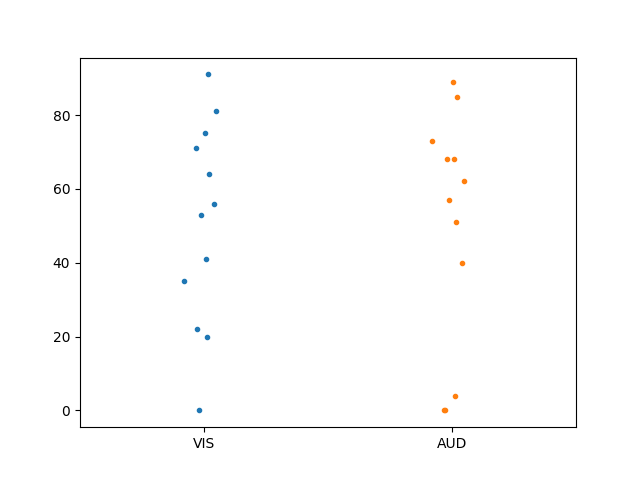

[Text(0, 0, 'VIS'), Text(1, 0, 'AUD')]

In [79]:
# plot num VIS and AUD units in separate columns

from numpy.random import default_rng
rng = default_rng()

jitter_x=rng.standard_normal(len(trial_summary_df))/30

fig,ax=plt.subplots(1,1)

ax.plot(np.zeros(len(unit_summary_df))+jitter_x,unit_summary_df['VIS_n'],'.')
ax.plot(np.ones(len(unit_summary_df))+jitter_x,unit_summary_df['AUD_n'],'.')

ax.set_xlim([-0.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels(['VIS','AUD'])

In [80]:
trial_summary_df

,session_date,mouseID,n_trials,n_vis_block_trials,n_aud_block_trials,n_catch,vis_go_500,vis_go_750,vis_go_1000,vis_nogo_500,...,aud_go_500,aud_go_750,aud_go_1000,aud_nogo_500,aud_nogo_750,aud_nogo_1000,hit_rate,fa_rate,fa_rel_rate,fa_irrel_rate
0,2022-07-26_14-09-36_620263,620263,673,615,0,58,59,41,58,53,...,48,49,56,54,47,53,0.993671,0.066019,0.086667,0.057534
1,2022-07-27_13-57-17_620263,620263,692,615,0,77,44,70,43,45,...,45,50,57,52,58,45,0.987261,0.031776,0.059603,0.020833
2,2022-08-02_15-40-19_620264,620264,702,0,627,75,56,51,49,44,...,46,51,63,51,54,50,1.000000,0.011070,0.012903,0.010336
3,2022-09-19_13-48-26_628801,628801,454,400,0,54,35,43,26,27,...,35,34,31,22,43,34,0.980769,0.480000,0.556701,0.450593
4,2022-09-26_12-48-09_636397,636397,629,0,565,64,54,42,44,42,...,50,51,44,45,52,43,0.917241,0.142562,0.235714,0.104651
5,2022-09-27_11-37-08_636397,636397,496,0,455,41,38,45,32,42,...,35,46,35,34,30,48,0.905172,0.300000,0.383929,0.264925
6,2022-12-05_13-08-02_644547,644547,701,644,0,57,59,50,55,46,...,58,65,37,59,56,45,0.737805,0.014898,0.006250,0.018568
7,2022-12-06_12-35-35_644547,644547,678,596,0,82,59,54,41,58,...,41,59,47,44,54,47,0.980519,0.072519,0.033333,0.088235
8,2023-01-17_11-39-17_646318,646318,675,0,611,64,36,60,56,59,...,53,51,52,53,46,54,0.935897,0.219653,0.588235,0.065574
9,2023-01-18_10-44-55_646318,646318,671,0,618,53,48,42,63,55,...,61,48,49,48,47,59,0.974684,0.157895,0.402597,0.052925


<IPython.core.display.Javascript object>


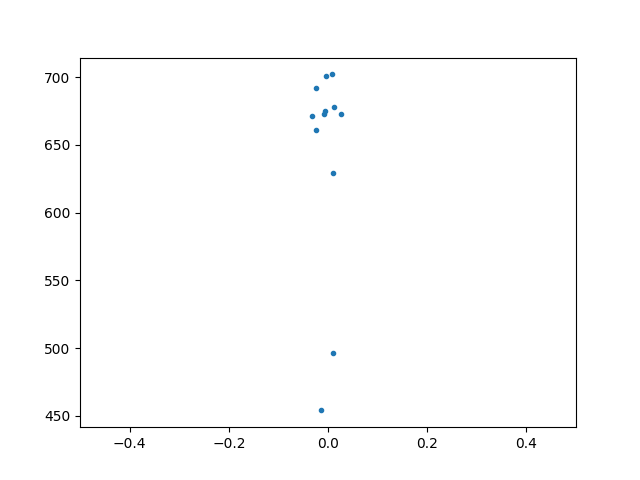

(-0.5, 0.5)

In [81]:
# plot total num trials across sessions (diff color/fill for AUD vs. VIS mice)
from numpy.random import default_rng
rng = default_rng()

jitter_x=rng.standard_normal(len(trial_summary_df))/50

fig,ax=plt.subplots(1,1)
ax.plot(jitter_x,trial_summary_df['n_trials'],'.')
ax.set_xlim([-.5,.5])

<IPython.core.display.Javascript object>


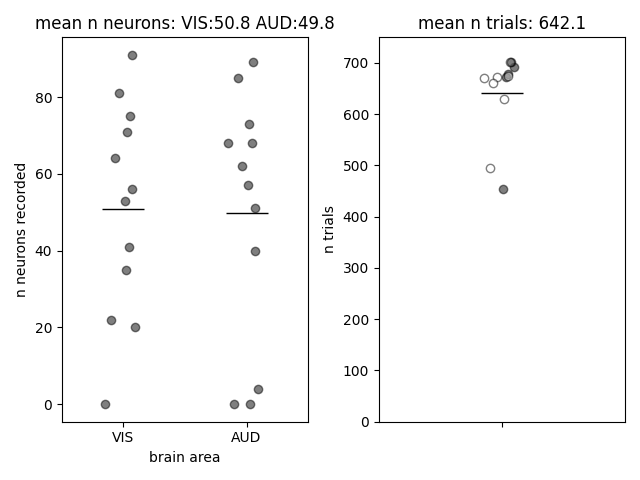

In [82]:
# plot both in a single plot

fig,ax=plt.subplots(1,2)

jitter_x=rng.standard_normal(len(trial_summary_df))/15

face_color='k'
for ss in range(0,len(unit_summary_df)):
    ax[0].plot(jitter_x[ss],unit_summary_df['VIS_n'][ss],'ko',markerfacecolor=face_color,alpha=0.5)
    ax[0].plot(1+jitter_x[ss],unit_summary_df['AUD_n'][ss],'ko',markerfacecolor=face_color,alpha=0.5)
ax[0].plot(0,np.nanmean(unit_summary_df['VIS_n']),'k_',markersize=30)
ax[0].plot(1,np.nanmean(unit_summary_df['AUD_n']),'k_',markersize=30)
    
ax[0].set_xlim([-0.5,1.5])
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['VIS','AUD'])

ax[0].set_xlabel('brain area')
ax[0].set_ylabel('n neurons recorded')

n_vis=np.round(np.nanmean(unit_summary_df['VIS_n']),decimals=1)
n_aud=np.round(np.nanmean(unit_summary_df['AUD_n']),decimals=1)
ax[0].set_title('mean n neurons: VIS:'+str(n_vis)+' AUD:'+str(n_aud))


for ss in range(0,len(unit_summary_df)):
    if modality[ss]=='vis':
        face_color='k'
    elif modality[ss]=='aud':
        face_color='white'
    ax[1].plot(jitter_x[ss],trial_summary_df['n_trials'][ss],'ko',markerfacecolor=face_color,alpha=0.5)

ax[1].plot(0,np.nanmean(trial_summary_df['n_trials']),'k_',markersize=30)
ax[1].set_xlim([-1,1])
ax[1].set_xticks([0])
ax[1].set_xticklabels([''])
ax[1].set_ylabel('n trials')
ax[1].set_ylim([0,750])

ntrials=np.round(np.nanmean(trial_summary_df['n_trials']),decimals=1)
ax[1].set_title('mean n trials: '+str(ntrials))

fig.tight_layout()